In [1]:
import jax
import flax
import optax
import numpy as np
import gymnasium as gym
from matplotlib import animation
import matplotlib.pyplot as plt
from jax import random, numpy as jnp

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=42)
obs, info

(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 {})

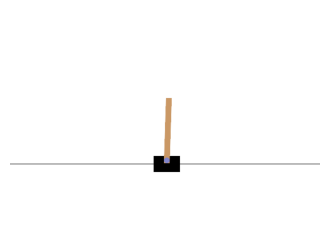

In [3]:
def show_env(env):
    img = env.render()
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')

show_env(env)

In [4]:
action=1
obs,reward,done,truncated,info = env.step(action)
obs, reward, done, truncated

(array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32),
 1.0,
 False,
 False)

In [5]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    totals.append(episode_rewards)

In [6]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

In [7]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

In [8]:
from flax import linen as nn
from jax import random, numpy as jnp

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

key, subkey = random.split(random.PRNGKey(0))
model = MLP()
params = model.init(subkey, obs[np.newaxis, :])
y = model.apply(params, obs[np.newaxis, :])

print('Initialized parameter shapes:\n', jax.tree_map(jnp.shape, params))
print('Output:\n', y)

Initialized parameter shapes:
 {'params': {'Dense_0': {'bias': (5,), 'kernel': (4, 5)}, 'Dense_1': {'bias': (1,), 'kernel': (5, 1)}}}
Output:
 [[0.04724307]]


In [9]:
key, subkey = random.split(key)
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
uniform_probs = random.uniform(subkey, (n_iterations, n_episodes_per_update, n_max_steps))
uniform_probs.shape

(150, 10, 200)

In [10]:
@jax.jit
def loss_fn(params, obs, uni_prob):
    logits = model.apply(params, obs[jnp.newaxis])
    left_proba = nn.sigmoid(logits)
    action = uni_prob > left_proba
    labels = jnp.array([[1.]]) - action
    return optax.sigmoid_binary_cross_entropy(logits, labels).mean(), action

def play_one_step(params, env, obs, uni_prob):
    grads, action = jax.jit(jax.grad(loss_fn, has_aux=True))(params, obs, uni_prob)
    obs, reward, done, truncated, _ = env.step(action.item())
    return obs, reward, done, truncated, grads

In [11]:
play_one_step(params, env, obs, uniform_probs[0, 0, 0])

/home/nils/miniconda3/envs/jax/lib/python3.11/site-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


(array([ 0.19670843,  0.1930188 , -0.23195486, -0.3000778 ], dtype=float32),
 0.0,
 True,
 False,
 {'params': {'Dense_0': {'bias': Array([ 0.        ,  0.        ,  0.28930318, -0.16624181,  0.        ],      dtype=float32),
    'kernel': Array([[ 0.        ,  0.        ,  0.05468395, -0.03142295,  0.        ],
           [ 0.        ,  0.        ,  0.11122123, -0.06391087,  0.        ],
           [-0.        , -0.        , -0.0641222 ,  0.03684644, -0.        ],
           [-0.        , -0.        , -0.14915381,  0.08570801, -0.        ]],      dtype=float32)},
   'Dense_1': {'bias': Array([-0.48819146], dtype=float32),
    'kernel': Array([[-0.        ],
           [-0.        ],
           [-0.12268365],
           [-0.28123042],
           [-0.        ]], dtype=float32)}}})

In [12]:
def play_multiple_episodes(env, n_episodes, n_max_steps, params, iter):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, _ = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                params, env, obs, uniform_probs[iter, episode, step]
            )
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated: break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [13]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards)-2, -1, -1):
        discounted[step] += discounted[step+1] * discount_factor 
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    mean, std = flat_rewards.mean(), flat_rewards.std()
    return jax.tree_map(lambda dr: (dr-mean)/std, all_discounted_rewards)

In [14]:
opt = optax.nadam(learning_rate=0.01)
opt_state = opt.init(params)
discount_factor = 0.95

In [15]:
for it in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, params, it 
    )

    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {it + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    params_arr, params_info = jax.tree_util.tree_flatten(params)
    for var_index in range(len(params_arr)):
        scaled_grads = jnp.array([reward * jax.tree_util.tree_leaves(all_grads[episode][step])[var_index]
                  for episode, rewards in enumerate(all_final_rewards)
                  for step, reward in enumerate(rewards)])
        mean_grads = jnp.mean(scaled_grads, axis=0)
        all_mean_grads.append(mean_grads)
    
    grads = jax.tree_util.tree_unflatten(params_info, all_mean_grads)
    #print(grads)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)


Iteration: 5/150, mean rewards: 29.1

KeyboardInterrupt: 

In [ ]:
def pg_policy(obs):
    left_proba = model.apply(params, obs[np.newaxis, :])
    return (np.random.rand() > left_proba).item()

show_one_episode(pg_policy)

In [ ]:
#TODO: why does training get slower over time?